
# 1D Forward Simulation for a Single Sounding

Here we use the module *simpeg.electromangetics.time_domain_1d* to predict
the stepoff response for a single sounding over a 1D layered Earth.
In this tutorial, we focus on the following:

    - Defining receivers, waveforms, sources and the survey
    - The units of the model and resulting data
    - Defining and running the 1D simulation for a single sounding

Our survey geometry consists of a horizontal loop source with a radius of 6 m
located 20 m above the Earth's surface. The receiver is located at the centre
of the loop and measures the vertical component of the response.


## Import Modules




In [1]:
import numpy as np
import os
from matplotlib import pyplot as plt

from simpeg import maps
import simpeg.electromagnetics.time_domain as tdem
from simpeg.utils import plot_1d_layer_model

write_output = False
plt.rcParams.update({"font.size": 16})

# sphinx_gallery_thumbnail_number = 2

## Create Survey

Here we demonstrate a general way to define the receivers, sources, waveforms and survey.
For this tutorial, the source is a horizontal loop whose current waveform
is a unit step-off. The receiver measures the vertical component of the magnetic flux
density at the loop's center.




In [2]:
# Source properties
source_location = np.array([0.0, 0.0, 20.0])
source_orientation = "z"  # "x", "y" or "z"
source_current = 1.0  # maximum on-time current
source_radius = 6.0  # source loop radius

# Receiver properties
receiver_location = np.array([0.0, 0.0, 20.0])
receiver_orientation = "z"  # "x", "y" or "z"
times = np.logspace(-5, -2, 31)  # time channels (s)

# Define receiver list. In our case, we have only a single receiver for each source.
# When simulating the response for multiple component and/or field orientations,
# the list consists of multiple receiver objects.
receiver_list = []
receiver_list.append(
    tdem.receivers.PointMagneticFluxDensity(
        receiver_location, times, orientation=receiver_orientation
    )
)

# Define the source waveform. Here we define a unit step-off. The definition of
# other waveform types is covered in a separate tutorial.
waveform = tdem.sources.StepOffWaveform()

# Define source list. In our case, we have only a single source.
source_list = [
    tdem.sources.CircularLoop(
        receiver_list=receiver_list,
        location=source_location,
        waveform=waveform,
        current=source_current,
        radius=source_radius,
    )
]

# Define the survey
survey = tdem.Survey(source_list)

## Defining a 1D Layered Earth Model

Here, we define the layer thicknesses and electrical conductivities for our
1D simulation. If we have N layers, we define N electrical conductivity
values and N-1 layer thicknesses. The lowest layer is assumed to extend to
infinity. If the Earth is a halfspace, the thicknesses can be defined by
an empty array, and the physical property values by an array of length 1.

In this case, we have a more conductive layer within a background halfspace.
This can be defined as a 3 layered Earth model.




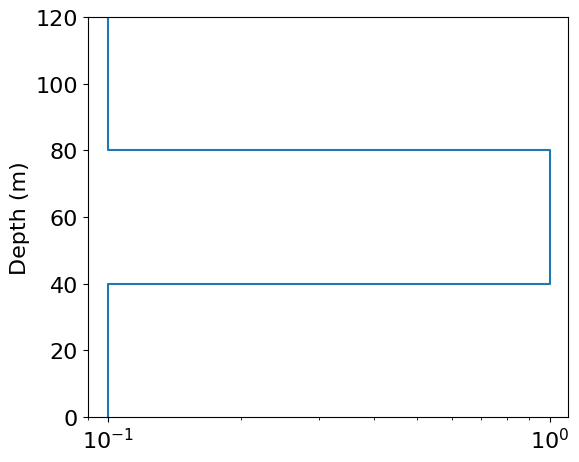

In [3]:
# Physical properties
background_conductivity = 1e-1
layer_conductivity = 1e0

# Layer thicknesses
thicknesses = np.array([40.0, 40.0])
n_layer = len(thicknesses) + 1

# physical property models
model = background_conductivity * np.ones(n_layer)
model[1] = layer_conductivity

# Define a mapping for conductivities
model_mapping = maps.IdentityMap(nP=n_layer)

# Plot conductivity model
thicknesses_for_plotting = np.r_[thicknesses, 40.0]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.8])
plot_1d_layer_model(thicknesses_for_plotting, model, ax=ax, show_layers=False)
plt.gca().invert_yaxis()

## Define the Forward Simulation, Predict Data and Plot

Here we define the simulation and predict the 1D TDEM sounding data.
The simulation requires the user define the survey, the layer thicknesses
and a mapping from the model to the conductivities of the layers.

When using the *simpeg.electromagnetics.time_domain_1d* module,
predicted data are organized by source, then by receiver, then by time channel.




Text(0.5, 1.0, 'Magnetic Flux')

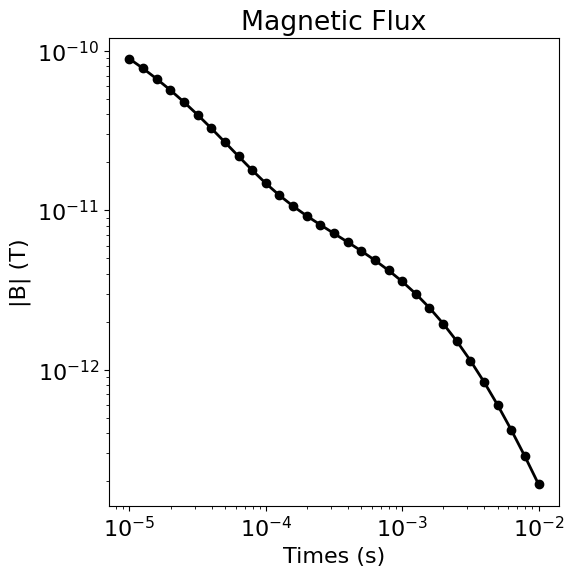

In [4]:
# Define the simulation
simulation = tdem.Simulation1DLayered(
    survey=survey,
    thicknesses=thicknesses,
    sigmaMap=model_mapping,
)

# Predict data for a given model
dpred = simulation.dpred(model)

# Plot sounding
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.2, 0.15, 0.75, 0.78])
ax.loglog(times, dpred, "k-o", lw=2)
ax.set_xlabel("Times (s)")
ax.set_ylabel("|B| (T)")
ax.set_title("Magnetic Flux")

## Write Output (Optional)




In [5]:
if write_output:
    dir_path = os.path.dirname(__file__).split(os.path.sep)
    dir_path.extend(["outputs"])
    dir_path = os.path.sep.join(dir_path) + os.path.sep

    if not os.path.exists(dir_path):
        os.mkdir(dir_path)

    np.random.seed(347)
    noise = 0.05 * np.abs(dpred) * np.random.randn(len(dpred))
    dpred += noise
    fname = dir_path + "em1dtm_data.txt"
    np.savetxt(fname, np.c_[times, dpred], fmt="%.4e", header="TIME BZ")